In [1]:
import os
from pathlib import Path

def root_dir(marker="EXPLib"):
    cwd = Path.cwd()
    # if cwd already contains the marker
    if (cwd / marker).is_dir():
        return cwd
    # otherwise walk up the parents
    for p in cwd.parents:
        if (p / marker).is_dir():
            return p
    raise FileNotFoundError(f"Root marker '{marker}' not found")

os.chdir(root_dir())
#print(os.getcwd())

In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from EXPLib.xai_library.model_explainers.plots.ale_pdp_plot_utils import plot_partial_dependence, plot_ale, train_xgb_surrogate
from EXPLib.xai_library.model_explainers.plots.ale_pdp_plot_utils import compute_and_append_features, build_dataset_from_json
from EXPLib.xai_library.model_explainers.plots.ale_pdp_plot_utils import BoosterWrapper, ALEModelWrapper, get_feature_names, feature_importance_dict, plot_feature_importances

In [3]:
IMAGE_DIR = './EXPLib/datasets/Camera/toy_model_v1_inference/dev/images'
PRED_JSON_PATH = './EXPLib/dl_component/CNN/Object_Detectors/toy_model_v1/toymodel_predictions_with_features.json'
OUTPUT_JSON_PATH = "./EXPLib/dl_component/CNN/Object_Detectors/toy_model_v1/toymodel_predictions_with_features.json"  

In [4]:
out_json = compute_and_append_features(PRED_JSON_PATH, IMAGE_DIR, OUTPUT_JSON_PATH)
df_meta, X, y = build_dataset_from_json(out_json)
print(f"Built dataset with {X.shape[0]} samples, feature dim = {X.shape[1]}.")

processing annotations: 100%|██████████| 9999/9999 [00:00<00:00, 3561382.96it/s]


Done. Computed features for 9999 annotations. Saved to ./EXPLib/dl_component/CNN/Object_Detectors/toy_model_v1/toymodel_predictions_with_features.json
Built dataset with 9999 samples, feature dim = 50.


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
bst, _, _, _, _ = train_xgb_surrogate(X_scaled, y)  

Train R2: 0.6593664857301329
Test  R2: -0.04909460363210072
Test MAE: 0.03559908220660873


In [6]:
feature_names = get_feature_names()
importances = feature_importance_dict(bst, feature_names)
top_k_features=6
top_idx = np.argsort(importances)[::-1][:min(4, len(importances))]
top_features = [feature_names[i] for i in top_idx]


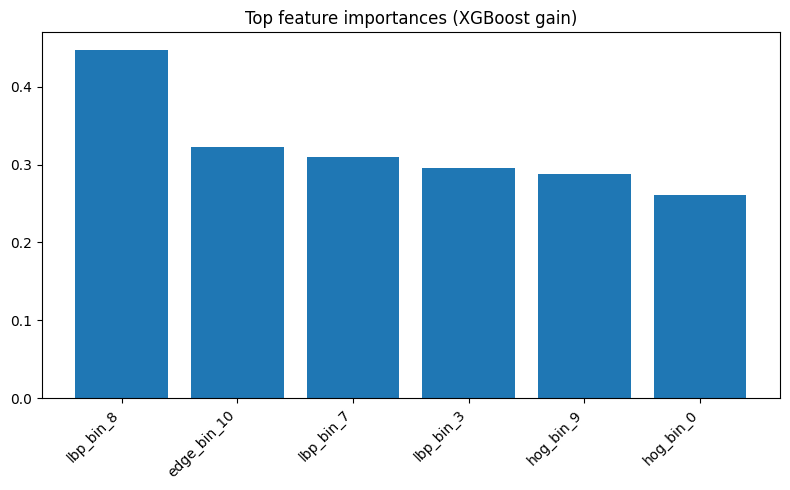

In [7]:

plot_feature_importances(feature_names, importances, top_k=top_k_features)

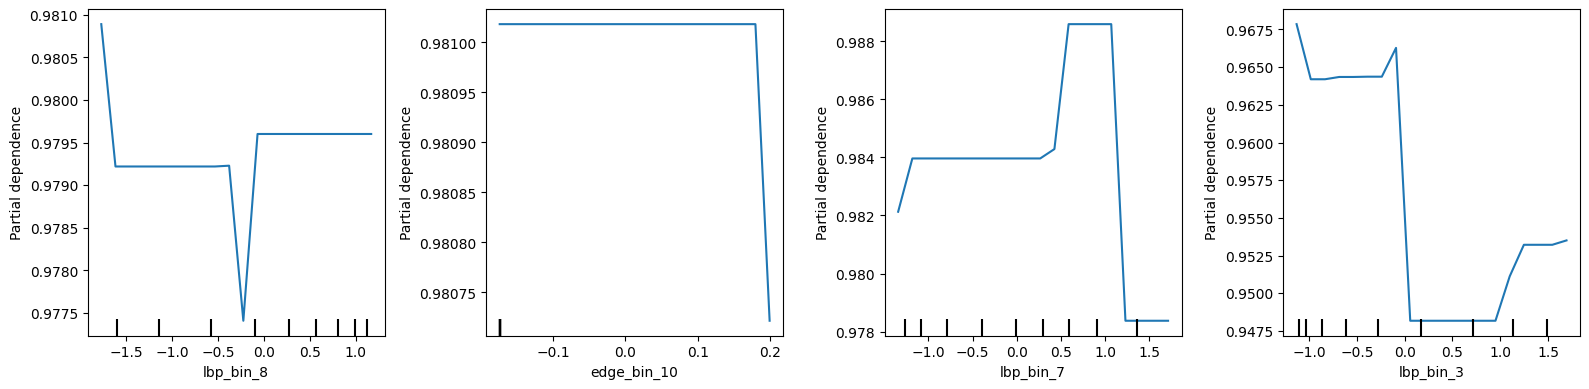

In [8]:
pdp_model = BoosterWrapper(bst)
pdp_model.fit(X_scaled)    
plot_partial_dependence(
        estimator=pdp_model,
        X=X_scaled,
        feature_names=feature_names,
        top_features=top_features
    )


PyALE._ALE_generic:INFO: Continuous feature detected.



Producing ALE for features: ['lbp_bin_8', 'edge_bin_10', 'lbp_bin_7', 'lbp_bin_3']


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


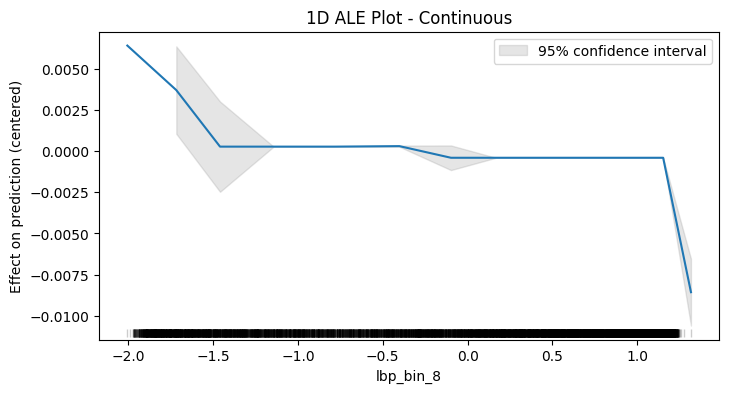

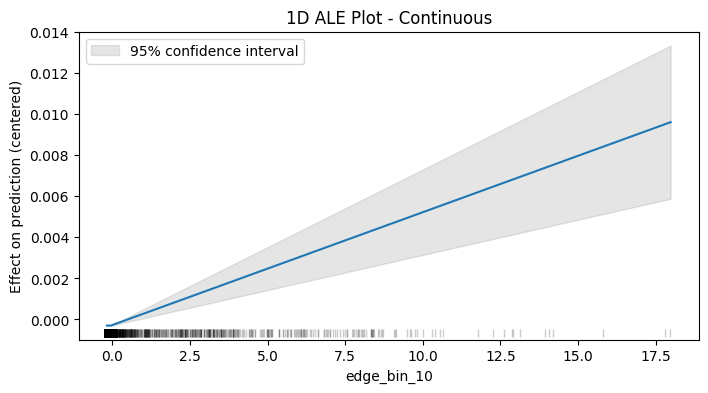

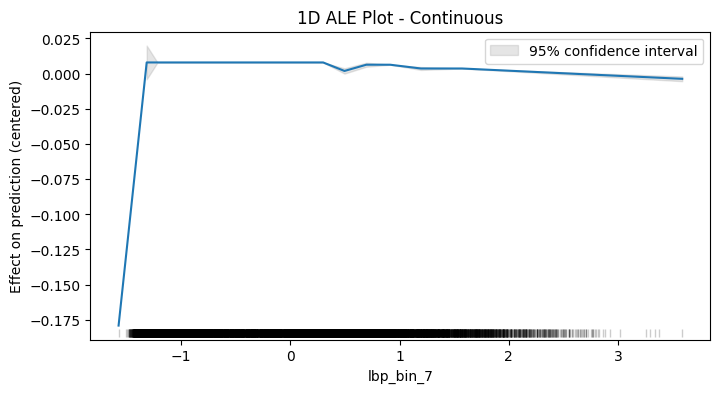

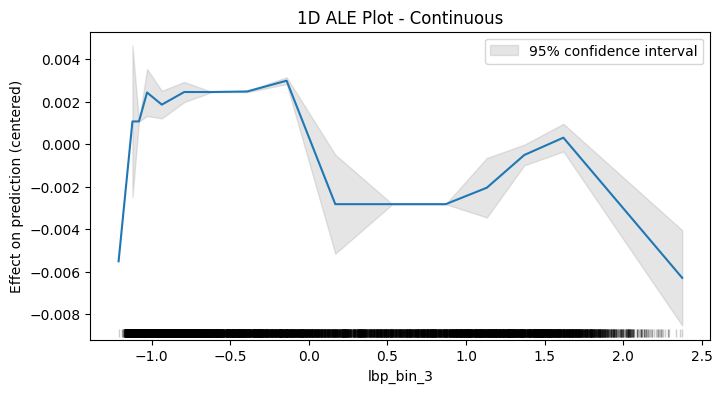

In [9]:
X_df = pd.DataFrame(X_scaled, columns=feature_names)
ale_model = ALEModelWrapper(bst)
print("\nProducing ALE for features:", top_features)
plot_ale(
    X_df=X_df,
    ale_model=ale_model,
    feature_names=feature_names,
    top_features=top_features
)
